In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn import linear_model
import seaborn as sns
import os

from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn import manifold as mfold

# READ CSV

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../../writing/walnut_figs/'
dst = '../hpcc/results/trad/'
perbasis = 'individual'
reltraits = np.array([24,23,21,26,51,49,13,14]) - iniN

filename = src + 'traditional_phenotype_summary.csv'
df = pd.read_csv(filename, dtype={1:str})
print(df.shape)
endN = df.shape[1]
df.head()

(1264, 52)


,UCACCSD,bname,wname,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,meat_ratio_cavity_area,meat_ratio_cavity_vol,rho_mvs,rho_vvs,rho_vvm,meat_ratio_feret,nut_vol_sa,meat_ratio_vol_sa,vein_ratio_vol_sa,shell_ratio_vol_sa
0,06-005-27,2008SB_R4_T13,1,41.750477,33.582913,31.395051,20387.149371,4.941865,1.329843,6147.314265,...,0.034601,0.031335,0.840804,0.592775,0.705009,1.526275,12880.783084,0.463951,0.195673,0.340377
1,06-005-27,2008SB_R4_T13,2,39.720443,33.450554,31.454860,20512.900734,4.643222,1.262776,6045.635968,...,0.033174,0.029986,0.846395,0.587884,0.694574,1.425155,13706.563584,0.469242,0.207626,0.323132
2,06-005-27,2008SB_R4_T13,3,42.790987,35.768852,33.257804,24394.576769,4.596968,1.286645,6763.478980,...,0.040115,0.037996,0.837089,0.598603,0.715100,1.486324,15546.904008,0.465462,0.203646,0.330892
3,06-005-27,2008SB_R4_T13,4,39.589858,34.400643,31.931823,21020.676969,4.496373,1.239825,6079.521052,...,0.031933,0.029688,0.840064,0.602599,0.717325,1.411052,14347.815998,0.482360,0.211936,0.305704
4,06-005-27,2008SB_R4_T13,5,38.284326,34.049830,31.365337,19995.849647,4.335537,1.220594,5809.316020,...,0.032905,0.032489,0.825360,0.586143,0.710167,1.314016,12806.076196,0.475517,0.186909,0.337574


In [3]:
filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)
labels.head()

(67, 2)


,col_labels,col_units
0,UCACCSD,
1,Batch Name,
2,Scan Name,
3,Nut Length,[mm]
4,Nut Height,[mm]


# Quantify variation

In [5]:
evalf = df.iloc[:,iniN:].describe().T.drop(columns=['count'])
evalf.index = labels.col_labels.iloc[iniN:endN].values
qcd = (evalf['75%'] - evalf['25%'])/(evalf['75%'] + evalf['25%'])
cv = evalf['std']/evalf['mean']
qdist = evalf['75%']/evalf['25%']
evalf['QCD'] = qcd
evalf['CV'] = cv

evalf['Units'] = labels.col_units.iloc[iniN:endN].values

filename = src + 'traditional_phenotype_variance_' + perbasis +'.csv'
print(filename)
evalf = evalf.loc[:,evalf.columns[[9,0,1,2,6,3,5,8,7]]].sort_values('QCD')
evalf.to_csv(filename, index=True, index_label="Phenotype", float_format='%.2f')

../hpcc/traditional/traditional_phenotype_variance_individual.csv


../hpcc/results/trad/trait_variation_highlight_relevant_individual


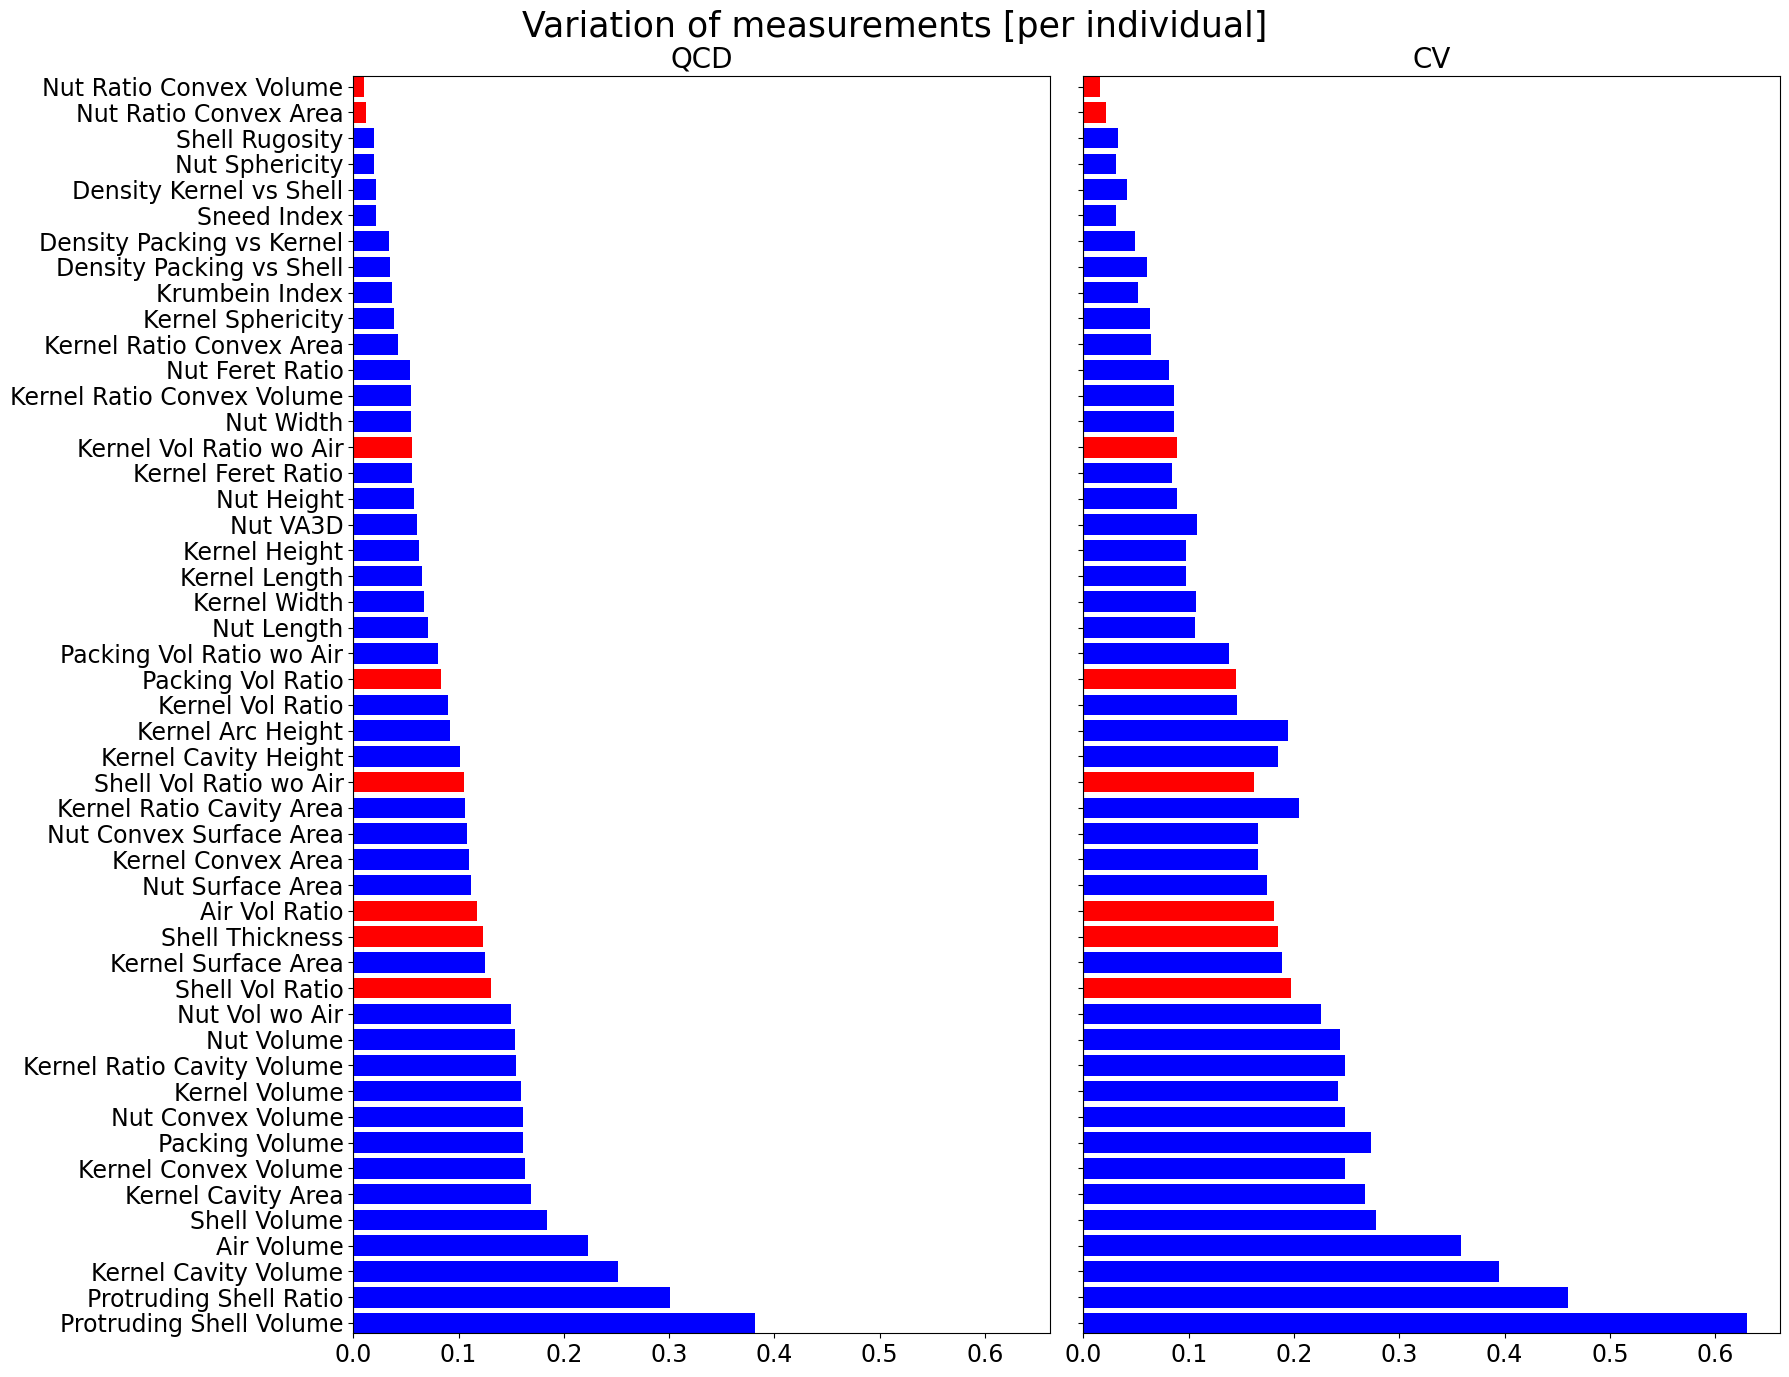

In [6]:
fs = 16
fig, ax = plt.subplots(1,2, figsize=(18,14), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0
sortarr = np.argsort(qcd.values)[::-1]
titles = ['QCD', 'CV']
xlocator = ticker.MaxNLocator(nbins=10, steps=np.arange(1,10))
xlocator = ticker.MultipleLocator(base=0.1)

for idx,vals in enumerate([qcd.values, cv.values]):
    ax[idx].barh(range(len(vals)), vals[sortarr], color='b')
    ax[idx].axvline(0, c='gray')
    ax[idx].set_yticks(range(len(vals)))
    ax[idx].set_yticklabels(labels.col_labels.iloc[iniN + sortarr].values);
    ax[idx].tick_params(labelrotation=0, labelsize=fs+1);
    ax[idx].xaxis.set_major_locator(xlocator)
    ax[idx].margins(y=0)
    ax[idx].set_title(titles[idx], fontsize=20)

foo = np.arange(len(vals))
foo = np.array([foo[sortarr == reltraits[i]][0] for i in range(len(reltraits))])
for idx,vals in enumerate([qcd.values, cv.values]):
    ax[idx].barh(foo, vals[sortarr][foo], color='r')
    
fig.suptitle('Variation of measurements [per '+perbasis+']', fontsize=25)
fig.tight_layout();

filename = dst + 'trait_variation_highlight_relevant_' + perbasis
print(filename)
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [4]:
rng = np.random.default_rng()
mmtraits = np.asarray(list(range(3,7)) + [9] + [11,12] + [17,18,19,20] + [26] + list(range(28,35)) + list(range(37,41)) + [48])
filename = src + 'traditional_log_R2_' +perbasis+'.csv'

ols_m = np.ones((len(mmtraits), len(mmtraits)))
ols_b = ols_m.copy()
ols_r = ols_m.copy()
ols_p = ols_m.copy()
ols_R2 = ols_m.copy()

if os.path.isfile(filename):
    foo = np.loadtxt(filename, delimiter=',')
    ols_m = foo[:len(ols_m)]
    ols_b = foo[len(ols_m):2*len(ols_m)]
    ols_p = foo[2*len(ols_m):3*len(ols_m)]
    ols_r = foo[3*len(ols_m):4*len(ols_m)]
    ols_R2= foo[4*len(ols_m):]
else:
    BB = 1000
    bootstrap = np.zeros((BB,5))

    for i in range(len(ols_m)):
        for j in range(len(ols_m)):        
            nonzero_i = set(np.nonzero(df.iloc[:,mmtraits[i]].values)[0])
            nonzero_j = set(np.nonzero(df.iloc[:,mmtraits[j]].values)[0])

            nonzero = np.asarray(list(nonzero_i & nonzero_j))

            trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
            trait_j = np.log(df.iloc[nonzero,mmtraits[j]].values)

            for k in range(BB):
                bb = rng.choice(len(trait_i), len(trait_i))
                ti = trait_i[bb]
                tj = trait_j[bb]

                ols = stats.linregress(ti, tj)

                bootstrap[k] = [ols.slope, 
                                ols.intercept, 
                                ols.pvalue, 
                                ols.rvalue, 
                                r2_score(tj, ols.slope*ti + ols.intercept)]

            bmeans = np.mean(bootstrap, axis = 0)

            ols_m[i, j] = bmeans[0]
            ols_b[i, j] = bmeans[1]
            ols_p[i, j] = bmeans[2]
            ols_r[i, j] = bmeans[3]
            ols_R2[i,j] = bmeans[4]
            
    np.savetxt(filename, np.vstack((ols_m, ols_b, ols_p, ols_r, ols_R2)), delimiter=',')

In [8]:
foo = pd.DataFrame(ols_R2, columns=labels.col_labels.iloc[mmtraits], index=labels.col_labels.iloc[mmtraits])
foo
#foo['Kernel Volume'].sort_values(ascending=False)

col_labels,Nut Length,Nut Height,Nut Width,Nut Volume,Nut Surface Area,Nut Convex Surface Area,Nut Convex Volume,Air Volume,Kernel Volume,Shell Volume,...,Kernel Height,Kernel Width,Kernel Surface Area,Kernel Convex Volume,Kernel Convex Area,Kernel Cavity Area,Kernel Cavity Volume,Kernel Arc Height,Kernel Cavity Height,Nut Vol wo Air
col_labels,,,,,,,,,,,,,,,,,,,,,
Nut Length,1.000000,0.336616,0.406834,0.615200,0.643326,0.652691,0.626906,0.396638,0.393949,0.436198,...,0.269049,0.209323,0.452247,0.493396,0.523929,0.401116,0.292853,0.040088,0.324793,0.535876
Nut Height,0.337276,1.000000,0.759264,0.859774,0.829310,0.844958,0.859358,0.656940,0.549277,0.436446,...,0.866453,0.581108,0.563963,0.745292,0.750503,0.324836,0.426000,0.019266,0.064491,0.676748
Nut Width,0.406830,0.759702,1.000000,0.862746,0.856703,0.859158,0.871631,0.620587,0.592815,0.453769,...,0.641507,0.745605,0.612682,0.767587,0.768929,0.391631,0.476733,0.014405,0.114372,0.711951
Nut Volume,0.614277,0.859790,0.862503,1.000000,0.968732,0.992953,0.996497,0.740829,0.648017,0.521159,...,0.730801,0.626044,0.688284,0.859226,0.875124,0.480322,0.522186,0.021615,0.184650,0.797454
Nut Surface Area,0.643176,0.829706,0.856563,0.968878,1.000000,0.984817,0.982576,0.724168,0.600451,0.533540,...,0.683728,0.605002,0.647148,0.810861,0.830942,0.449177,0.495619,0.025114,0.167918,0.767840
Nut Convex Surface Area,0.653369,0.844975,0.859586,0.992938,0.984764,1.000000,0.998568,0.736612,0.629597,0.536727,...,0.708410,0.606936,0.672983,0.840499,0.861125,0.471905,0.508083,0.025182,0.182875,0.790315
Nut Convex Volume,0.625639,0.858830,0.871674,0.996481,0.982551,0.998572,1.000000,0.739664,0.637019,0.531077,...,0.723882,0.623968,0.677646,0.849269,0.867287,0.470336,0.513273,0.022538,0.176272,0.792835
Air Volume,0.397401,0.657907,0.620283,0.741509,0.724930,0.736438,0.739668,1.000000,0.217030,0.177894,...,0.470229,0.387333,0.290243,0.487929,0.509435,0.313099,0.366993,0.004710,0.066606,0.299191
Kernel Volume,0.394989,0.548607,0.593397,0.647792,0.600769,0.628680,0.637040,0.216920,1.000000,0.370298,...,0.664451,0.598671,0.899405,0.884742,0.868949,0.420907,0.404781,0.027985,0.291130,0.870159


In [9]:
for i in range(0,len(mmtraits)):
    print(i,mmtraits[i], labels.col_labels.iloc[mmtraits[i]], labels.col_units.iloc[mmtraits[i]], df.columns[mmtraits[i]],sep='\t')

0	3	Nut Length	 [mm]	nut_length
1	4	Nut Height	 [mm]	nut_height
2	5	Nut Width	 [mm]	nut_width
3	6	Nut Volume	 [mm$^3$]	nut_vol
4	9	Nut Surface Area	 [mm$^2$]	nut_area
5	11	Nut Convex Surface Area	 [mm$^2$]	nut_cnvx_area
6	12	Nut Convex Volume	 [mm$^3$]	nut_cnvx_vol
7	17	Air Volume	 [mm$^3$]	air_vol
8	18	Kernel Volume	 [mm$^3$]	meat_vol
9	19	Shell Volume	 [mm$^3$]	shell_vol
10	20	Packing Volume	 [mm$^3$]	vein_vol
11	26	Shell Thickness	 [mm]	shell_thickness
12	28	Protruding Shell Volume	 [mm$^3$]	shell_prot_vol
13	29	Kernel Length	 [mm]	meat_length
14	30	Kernel Height	 [mm]	meat_height
15	31	Kernel Width	 [mm]	meat_width
16	32	Kernel Surface Area	 [mm$^2$]	meat_area
17	33	Kernel Convex Volume	 [mm$^3$]	meat_cnvx_vol
18	34	Kernel Convex Area	 [mm$^2$]	meat_cnvx_area
19	37	Kernel Cavity Area	 [mm$^2$]	meat_cavity_area
20	38	Kernel Cavity Volume	 [mm$^3$]	meat_cavity_vol
21	39	Kernel Arc Height	 [mm]	meat_arc_height
22	40	Kernel Cavity Height	 [mm]	meat_cavity_height
23	48	Nut Vol wo Air	 [

In [11]:
if False:
    i = 3
    j = 7
    
    xrange = np.linspace(1e6, 2e7, 100)
    bar = np.exp(-ols_b[i,j]/(ols_m[i,j]-1))
    plt.figure(figsize=(10,5))
    
    plt.plot(xrange, np.exp(ols_b[i,j])*np.power(xrange,ols_m[i,j]))
    plt.plot(xrange, xrange, c='r');
    
    plt.xlabel(new_col_labels[mmtraits[i]])
    plt.ylabel(new_col_labels[mmtraits[j]])
    
    plt.axvline(bar, c='k')
    print(bar)
    print(np.cbrt(3*bar/(4*np.pi)))
    print(2*np.cbrt(3*bar/(4*np.pi)))

../hpcc/results/trad/nut_volume_allometry_individual_5x4


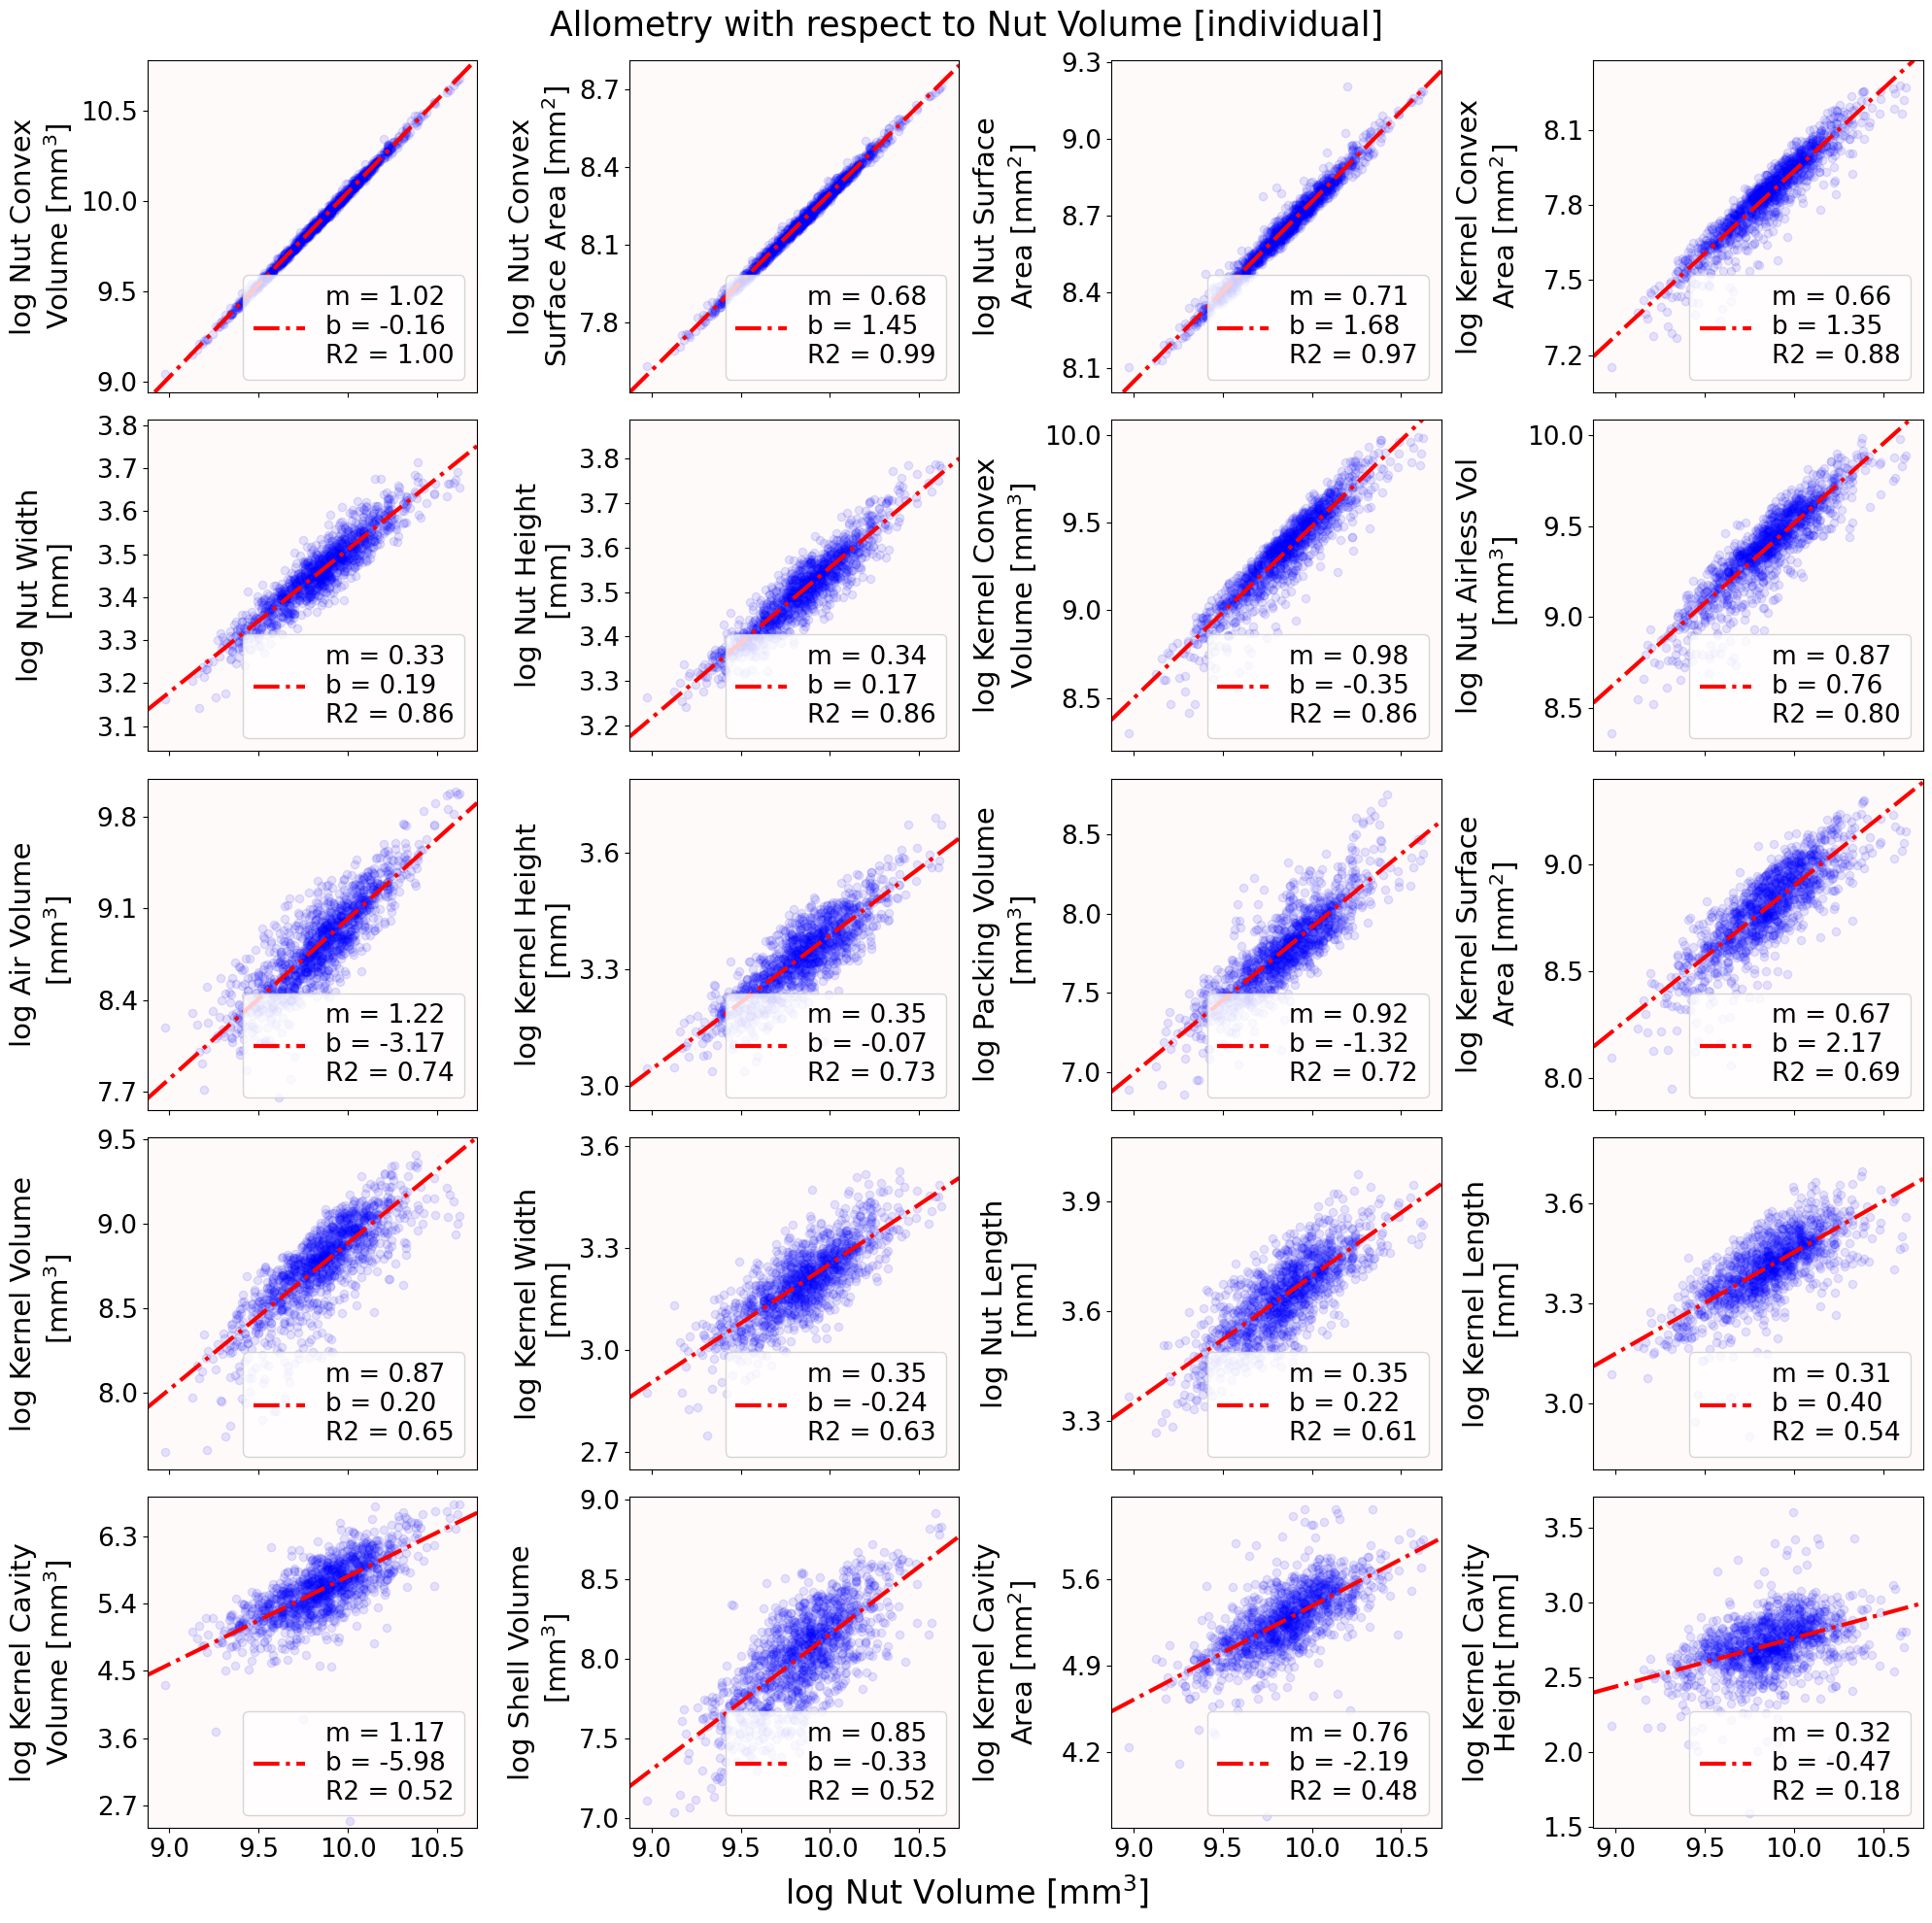

In [23]:
fs = 19
fig, ax = plt.subplots(5,4, figsize=(20,20), sharex=True)
ax = np.atleast_1d(ax).ravel()

i = 3
TRAIT_I = np.log(df.iloc[:,mmtraits[i]].values)
argsort = np.argsort(ols_R2[i])[::-1][1:]

for idx in range(len(ax)):
    j = mmtraits[argsort[idx]]
    nonzero = np.nonzero(df.iloc[:,j].values)[0]
    if len(nonzero) == len(df):
        trait_i = TRAIT_I.copy()
        trait_j = np.log(df.iloc[:,j].values)
    else:
        trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
        trait_j = np.log(df.iloc[nonzero,j].values)
        
    ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=fs)
    
    m = ols_m[i,argsort[idx]]
    r2 = ols_R2[i,argsort[idx]]
    b = ols_b[i,argsort[idx]]

    axlabel = 'm = {:.2f}\nb = {:.2f}\nR2 = {:.2f}'.format(m,b,r2)
    bar = ax[idx].axline(xy1=(0,b), slope=m, color='r', label=axlabel, ls='-.', lw=3)

    ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.1)
    ylabel = 'log ' + labels.col_labels.iloc[j] 
    if len(ylabel) < 20:
        ylabel += '\n' + labels.col_units.iloc[j]
    else:
        ylabel = textwrap.fill(ylabel, 19) + labels.col_units.iloc[j]
    ax[idx].set_ylabel(ylabel, fontsize=fs+2);
    ax[idx].legend(loc='lower right', fontsize=fs)
    
    ylocator = ticker.MaxNLocator(steps=np.arange(1,11,2), nbins=5, min_n_ticks=3)
    ax[idx].yaxis.set_major_locator(ylocator)
    #ax[idx].xaxis.set_major_locator(xlocator)

fig.align_ylabels()
fig.supxlabel('log ' + labels.col_labels.iloc[mmtraits[i]] + labels.col_units.iloc[mmtraits[i]], fontsize=fs+5);
fig.suptitle('Allometry with respect to ' + labels.col_labels.iloc[mmtraits[i]] + ' ['+perbasis+']', fontsize=25, y=.99)
fig.tight_layout()

filename = dst + labels.col_labels.iloc[mmtraits[i]].lower().replace(' ','_') + '_allometry_' +perbasis +'_5x4'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

../hpcc/traditional/results/nut_convex_volume_vs_nut_volume
../hpcc/traditional/results/nut_convex_surface_area_vs_nut_volume


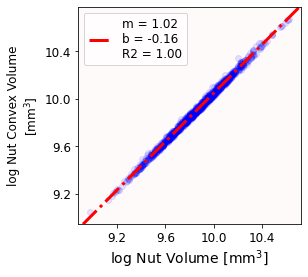

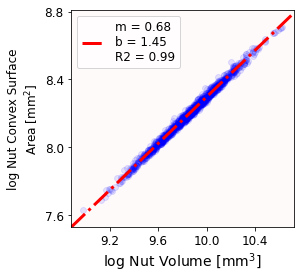

In [71]:
fs = 12
i = 3
TRAIT_I = np.log(df.iloc[:,mmtraits[i]].values)
argsort = np.argsort(ols_R2[i])[::-1][1:]

for idx in range(2):
    fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)

    j = mmtraits[argsort[idx]]
    nonzero = np.nonzero(df.iloc[:,j].values)[0]
    if len(nonzero) == len(df):
        trait_i = TRAIT_I.copy()
        trait_j = np.log(df.iloc[:,j].values)
    else:
        trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
        trait_j = np.log(df.iloc[nonzero,j].values)
        
    ax.set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax.set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax.set_facecolor('snow')
    ax.tick_params(labelsize=fs)
    
    m = ols_m[i,argsort[idx]]
    r2 = ols_R2[i,argsort[idx]]
    b = ols_b[i,argsort[idx]]

    axlabel = 'm = {:.2f}\nb = {:.2f}\nR2 = {:.2f}'.format(m,b,r2)
    bar = ax.axline(xy1=(0,b), slope=m, color='r', label=axlabel, ls='-.', lw=3)

    ax.scatter(trait_i, trait_j, color='b', alpha=0.1)
    ylabel = 'log ' + labels.col_labels.iloc[j] + labels.col_units.iloc[j]
    ax.set_ylabel(textwrap.fill(ylabel,25), fontsize=fs);
    ax.legend(loc='upper left', fontsize=fs)
    ax.set_xlabel('log ' + labels.col_labels.iloc[mmtraits[i]] + labels.col_units.iloc[mmtraits[i]], fontsize=fs+2);
    ax.locator_params('both', nbins=5, steps=[2,4,6,8,10])
    
    filename = dst + labels.col_labels.iloc[j].lower().replace(' ','_') + '_vs_' + labels.col_labels.iloc[mmtraits[i]].lower().replace(' ','_')
    print(filename)
    #plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    #plt.close()

../../writing/walnut_figs/individual_tissue_allometry_individual


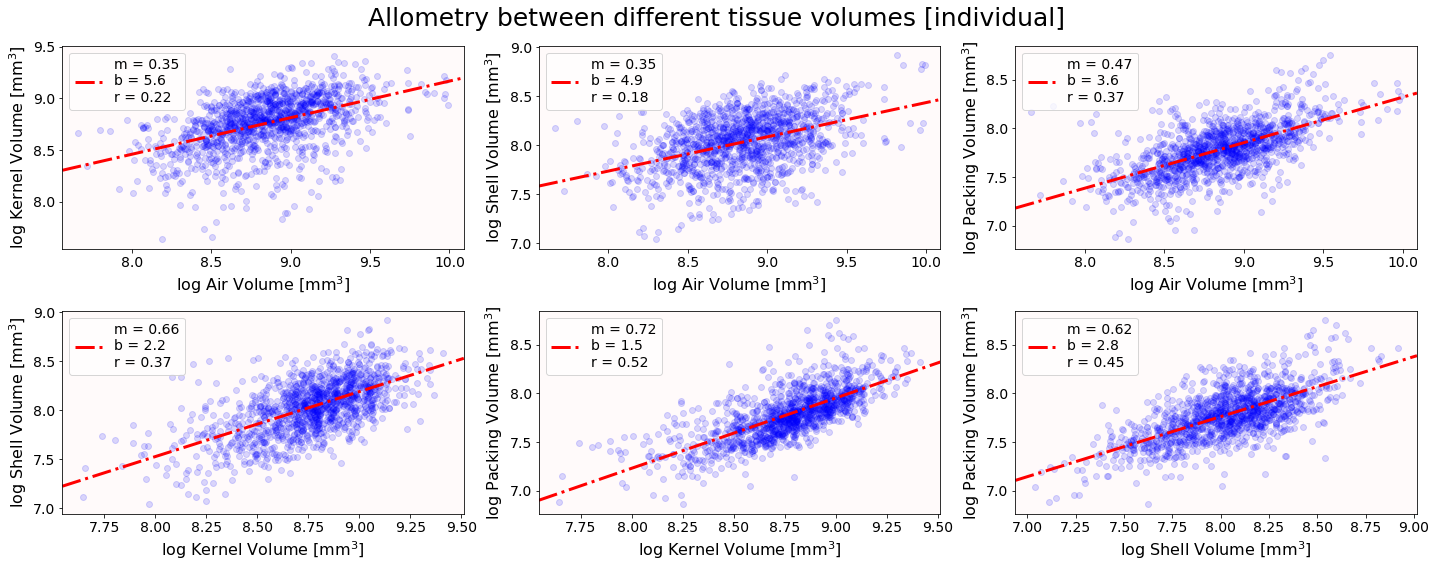

In [12]:
fs = 14
fig, ax = plt.subplots(2,3, figsize=(20,8))
ax = np.atleast_1d(ax).ravel()

idx = 0
for i in range(17,21):
    trait_i = np.log(df.iloc[:,i].values)
    for j in range(i+1, 21):
        trait_j = np.log(df.iloc[:,j].values)
        r,p = stats.pearsonr(trait_i, trait_j)

        ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
        ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
        ax[idx].set_facecolor('snow')
        ax[idx].tick_params(labelsize=fs)

        new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(trait_j, new_series(trait_i))
        axlabel = 'm = {:.2}\nb = {:.2}\nr = {:.2}'.format(foo[1], foo[0], r2)
        bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='r', label=axlabel, ls='-.', lw=3)

        ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.15)
        ax[idx].set_ylabel('log ' + labels.col_labels.iloc[j] + labels.col_units.iloc[j], fontsize=fs+2);
        ax[idx].set_xlabel('log ' + labels.col_labels.iloc[i] + labels.col_units.iloc[i], fontsize=fs+2);
        ax[idx].legend(loc='upper left', fontsize=fs)
        idx += 1

#for idx in range(10,len(ax)):
#    ax[idx].set_xlabel('log ' + col_labels[i] + col_units[i], fontsize=fs+2);

fig.suptitle('Allometry between different tissue volumes ['+perbasis+']', fontsize=25)
fig.tight_layout()
filename = dst + 'individual_tissue_allometry_' +perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

In [7]:
feats = df.iloc[:,iniN:].values.copy()

pcorrstat = np.ones((feats.shape[1], feats.shape[1]))
ppvalcorr = np.zeros_like(pcorrstat)

scorrstat = np.ones((feats.shape[1], feats.shape[1]))
spvalcorr = np.zeros_like(pcorrstat)

for i in range(len(pcorrstat)-1):
    for j in range(i+1, len(pcorrstat)):
        pstat, ppval = stats.pearsonr(feats[:,i], feats[:,j])
        sstat, spval = stats.spearmanr(feats[:,i], feats[:,j])
        
        pcorrstat[i,j] = pstat
        pcorrstat[j,i] = pstat
        ppvalcorr[i,j] = ppval
        ppvalcorr[j,i] = ppval
        
        scorrstat[i,j] = sstat
        scorrstat[j,i] = sstat
        spvalcorr[i,j] = spval
        spvalcorr[j,i] = spval

In [8]:
for j in range(iniN, len(labels)):
    print(j-iniN, labels.col_labels.iloc[j], len(labels.col_labels.iloc[j]), sep='\t')

0	Nut Length	10
1	Nut Height	10
2	Nut Width	9
3	Nut Volume	10
4	Nut VA3D	8
5	Nut Feret Ratio	15
6	Nut Surface Area	16
7	Nut Sphericity	14
8	Nut Convex Surface Area	23
9	Nut Convex Volume	17
10	Nut Ratio Convex Area	21
11	Nut Ratio Convex Volume	23
12	Krumbein Index	14
13	Sneed Index	11
14	Air Volume	10
15	Kernel Volume	13
16	Shell Volume	12
17	Packing Volume	14
18	Air Vol Ratio	13
19	Kernel Vol Ratio	16
20	Shell Vol Ratio	15
21	Packing Vol Ratio	17
22	Shell Rugosity	14
23	Shell Thickness	15
24	Protruding Shell Ratio	22
25	Protruding Shell Volume	23
26	Kernel Length	13
27	Kernel Height	13
28	Kernel Width	12
29	Kernel Surface Area	19
30	Kernel Convex Volume	20
31	Kernel Convex Area	18
32	Kernel Ratio Convex Area	24
33	Kernel Ratio Convex Volume	26
34	Kernel Cavity Area	18
35	Kernel Cavity Volume	20
36	Kernel Arc Height	17
37	Kernel Cavity Height	20
38	Kernel Sphericity	17
39	Kernel Ratio Cavity Area	24
40	Kernel Ratio Cavity Volume	26
41	Density Kernel vs Shell	23
42	Density Packing vs S

../hpcc/results/trad/spearman_correlation


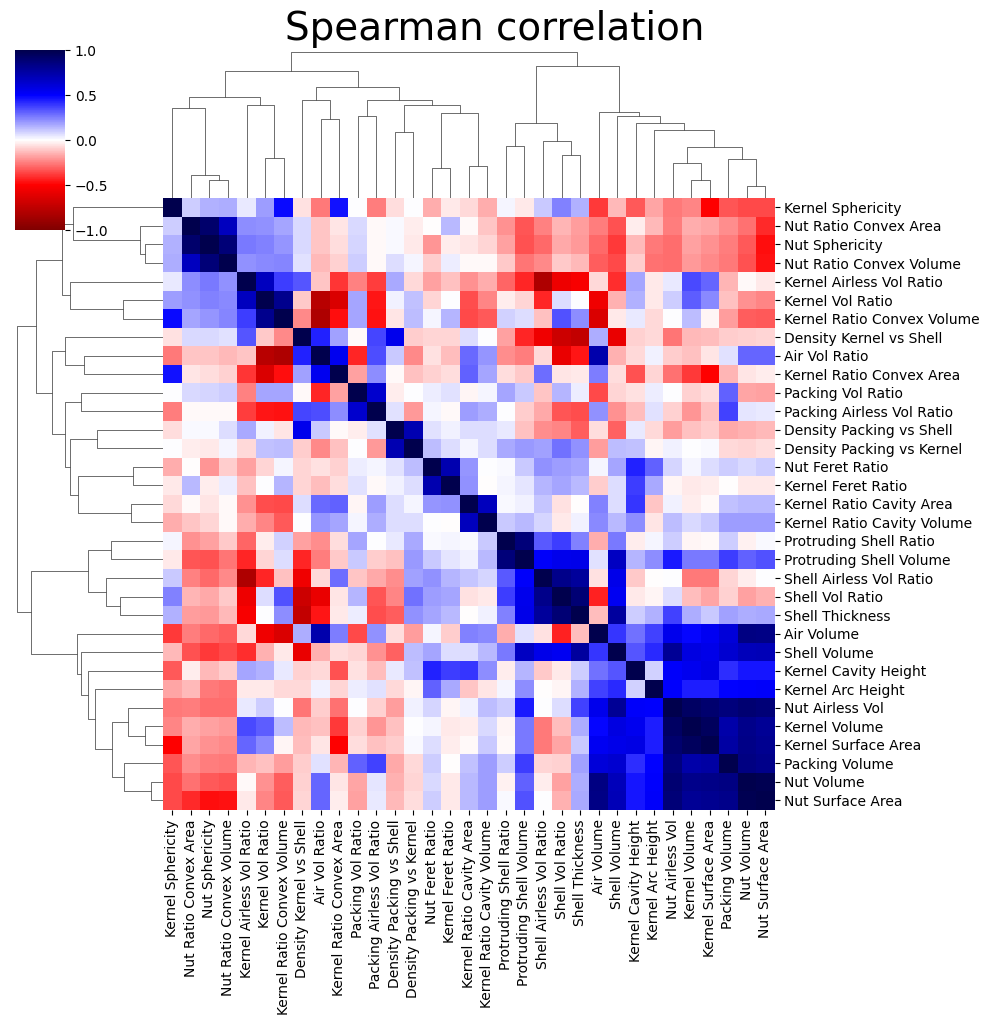

In [22]:
dropsubset = [0,1,2,4,8,9] + [12,13] + [22] + [26,27,28,30,31,34,35]

vmin, vmax = -1,1
cmap = 'seismic_r'
foo = pd.DataFrame(scorrstat, columns=labels.col_labels.iloc[iniN:endN].values, 
                   index=labels.col_labels.iloc[iniN:endN].values)
foo = foo.drop(columns=foo.columns[dropsubset], index=foo.index[dropsubset])

cluster = sns.clustermap(foo, vmax=vmax, vmin=vmin, cmap=cmap);
dendidx = np.asarray(cluster.dendrogram_col.reordered_ind)

plt.suptitle('Spearman correlation', fontsize=28, y=1.02);

filename = dst + 'spearman_correlation'
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

In [10]:
foo = pd.DataFrame(scorrstat, columns=labels.col_labels.iloc[iniN:endN].values, index=labels.col_labels.iloc[iniN:endN].values)
trait = 'Kernel Volume'
args = np.argsort(np.abs(foo[trait].values))[::-1]
foo[trait].iloc[args]

Kernel Volume                 1.000000
Kernel Surface Area           0.947534
Kernel Convex Volume          0.942751
Kernel Convex Area            0.934877
Nut Airless Vol               0.931528
Nut Volume                    0.823760
Nut Convex Volume             0.816937
Nut Convex Surface Area       0.812227
Kernel Height                 0.806657
Nut Surface Area              0.796047
Nut Width                     0.779117
Kernel Length                 0.768413
Kernel Width                  0.767337
Nut Height                    0.755374
Packing Volume                0.738834
Kernel Cavity Area            0.674965
Kernel Cavity Volume          0.664094
Nut Length                    0.619166
Shell Volume                  0.582407
Kernel Cavity Height          0.539557
Air Volume                    0.491359
Kernel Arc Height             0.443410
Kernel Ratio Convex Area     -0.389392
Kernel Airless Vol Ratio      0.358649
Kernel Vol Ratio              0.313193
Protruding Shell Volume  

In [13]:
argsort = np.argsort(np.sum(np.abs(scorrstat[reltraits, :]), axis=0))[::-1]
corr = scorrstat[reltraits, :][:, argsort]

foo = np.arange(corr.shape[1])
foo = np.argsort(np.array([foo[corr[i] == 1][0] for i in range(len(reltraits))]))

corr = corr[foo, :]

pval = -np.log10(spvalcorr[reltraits, :]*corr.size + 1e-100)
pval = pval[:, argsort]
pval = pval[foo, :]

array(['Shell Vol Ratio', 'Shell Vol Ratio wo Air', 'Shell Thickness',
       'Kernel Vol Ratio wo Air', 'Air Vol Ratio',
       'Nut Ratio Convex Area', 'Nut Ratio Convex Volume',
       'Packing Vol Ratio'], dtype=object)

../hpcc/results/trad/quant_correlation_coefficients_h_per_individual


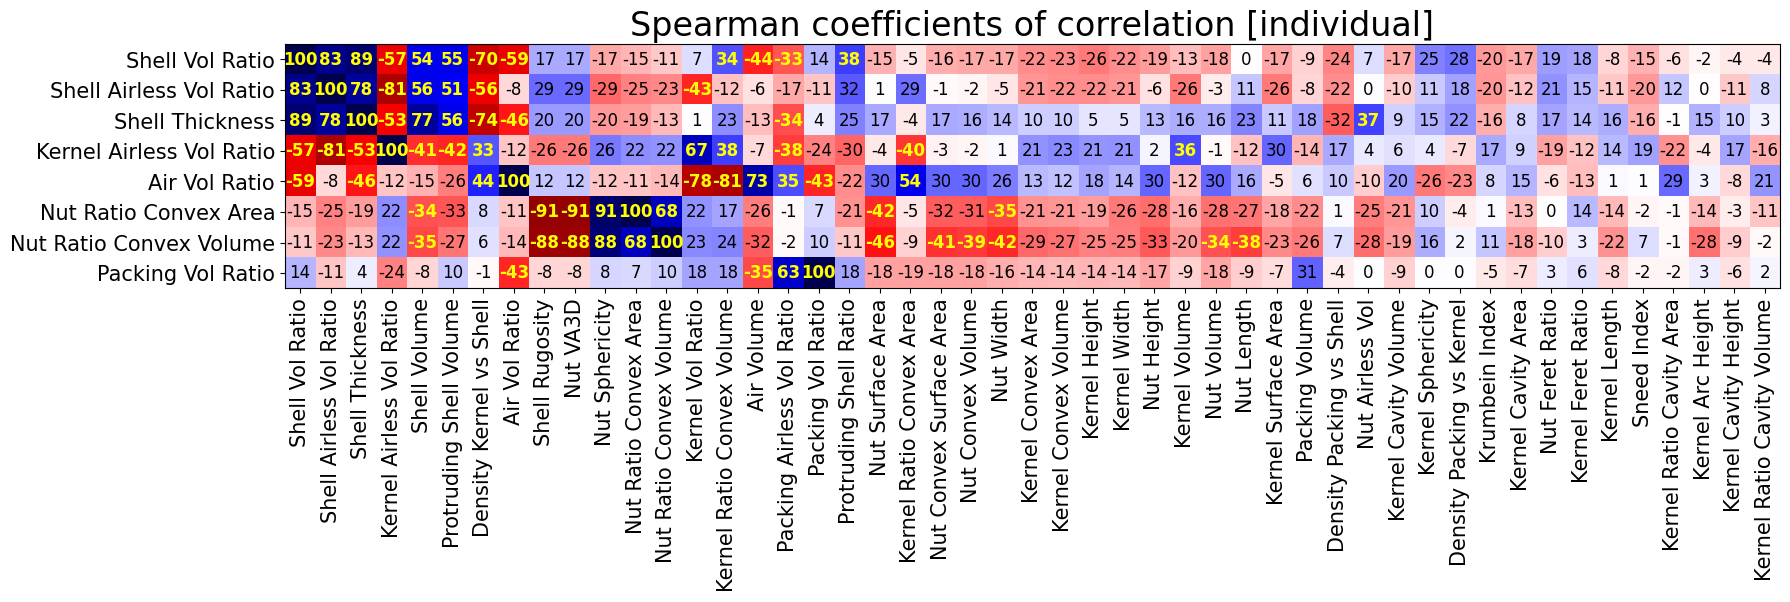

In [20]:
fig, ax = plt.subplots(1,1,figsize=(18,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); k=0

ax[k].imshow(corr, cmap='seismic_r', vmin=-1, vmax=1)

# We want to show all ticks...
ax[k].set_yticks(np.arange(corr.shape[0]), labels.col_labels.iloc[iniN+reltraits].iloc[foo].values)
ax[k].set_xticks(np.arange(corr.shape[1]), labels.col_labels.iloc[iniN+argsort].values,
                rotation=90, ha='right', va='center', rotation_mode='anchor')

ax[k].tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax[k].text(j,i, '{:d}'.format(int(np.round(100*corr[i,j]))),
                       ha="center", va="center", color=tcolor, fontsize=12, fontweight=fw)

ax[k].set_title("Spearman coefficients of correlation ["+perbasis+"]", fontsize=24)

k = 1
#ax[k].imshow(pval, cmap='Blues', vmin=1, vmax=2)
#ax[k].set_xticks(np.arange(corr.shape[1]), labels=np.arange(corr.shape[1]), 
#                 rotation=90, ha='right', va='center', rotation_mode='anchor')

fig.tight_layout()

filename = dst + 'quant_correlation_coefficients_h_per_' + perbasis
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

(34,)
(35,)
../hpcc/results/trad/combination_hbar_correlation


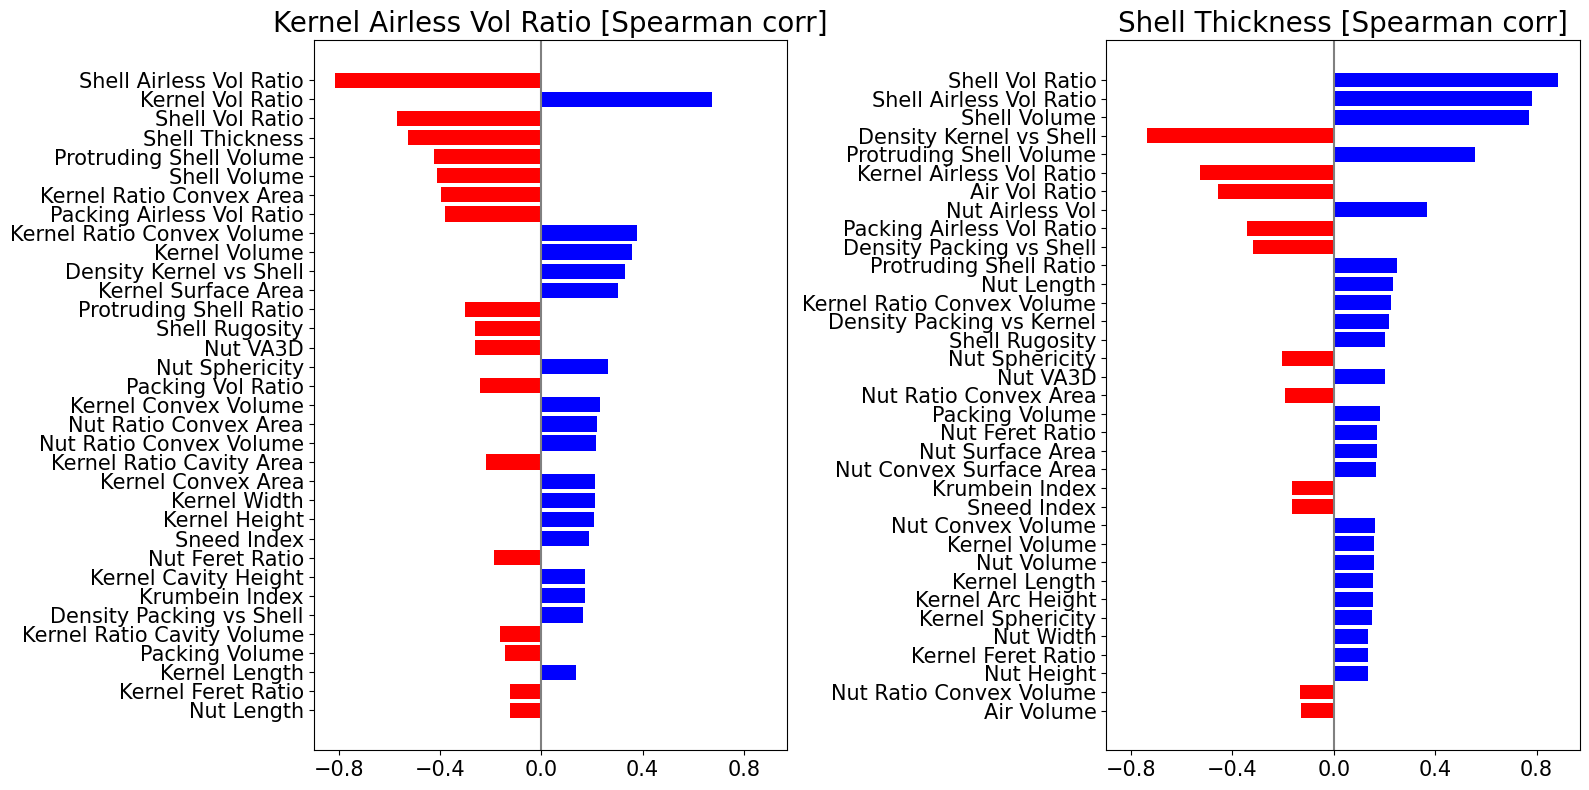

In [21]:
fs = 15
fig, ax = plt.subplots(1,2, figsize=(16,8), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for idx,i in enumerate([49,26]):
    pval = spvalcorr[i-iniN]
    pval = np.hstack((pval[:i-2],pval[i-1:]))
    tags = np.hstack((labels.col_labels.iloc[iniN:i],labels.col_labels.iloc[i+1:endN]))
    
    vals = scorrstat[i-iniN]
    diff = vals - pcorrstat[i-iniN]
    
    vals = np.hstack((vals[:i-iniN],vals[i-iniN+1:]))
    diff = np.hstack((diff[:i-iniN],diff[i-iniN+1:]))
    
    bonferroni = 1e-3/len(vals)
    vals = vals[pval < bonferroni]
    diff = diff[pval < bonferroni]
    tags = tags[pval < bonferroni]
    
    print(vals.shape)
    
    sortarr = np.argsort(np.abs(vals))
    plus = np.where(vals[sortarr] > 0)[0]
    minus = np.where(vals[sortarr] < 0)[0]
    

    ax[idx].barh(plus, vals[sortarr][plus], color='b')
    ax[idx].barh(minus, vals[sortarr][minus], color='r')
    xlocator = ticker.MaxNLocator(steps=np.arange(2,11,2), nbins=5, min_n_ticks=3)
    ax[idx].xaxis.set_major_locator(xlocator)
    
    ax[idx].axvline(0, c='gray')
    ax[idx].set_yticks(range(len(vals)))
    ax[idx].set_yticklabels(tags[sortarr]);
    ax[idx].tick_params(labelsize=fs);
    ax[idx].set_title(labels.col_labels.iloc[i] + ' [Spearman corr]', fontsize=20)
    #ax[idx].set_aspect('equal')
fig.tight_layout();

filename = dst + labels.col_labels.iloc[i].lower().replace(' ','_') + '_hbar_correlation'
filename = dst + 'combination_hbar_correlation'
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

# Correlation

In [24]:
if perbasis != 'individual':
    #qtraits = np.array([21,22,23,24] + [49,51,50] + [44])
    qtraits = np.array([21,22,23,24] + [49,51,50] + [44] + [26])
    ptraits = qtraits.copy()
    filename = src + 'vol_ratios_spearman_correlation_pvals_'+perbasis+'.csv' 

    if os.path.isfile(filename):

        foo = np.loadtxt(filename, delimiter=',')
        scorrstat = foo[:len(qtraits)]
        spvalcorr = foo[len(qtraits):]

    else:
        import resampling

        scorrstat = np.ones((len(qtraits), len(ptraits)))
        spvalcorr = np.zeros_like(scorrstat)

        feats = df.iloc[:, offset:].values.copy()

        for i in range(len(qtraits)):
            for j in range(i):
                x = feats[:,qtraits[i] - iniN]
                y = feats[:,ptraits[j] - iniN]
                sstat, spval = stats.spearmanr(x,y)
                scorrstat[i,j] = sstat
                spvalcorr[i,j] = spval

                if len(y) < 500:
                    def statistic(x):  # permute only `x`
                        return stats.spearmanr(x, y).correlation

                    spval = resampling.permutation_test((x,), statistic, permutation_type='pairings')
                    spvalcorr[i,j] = spval.pvalue

        np.savetxt(filename, np.vstack((scorrstat, spvalcorr)), delimiter=',')

    corr = scorrstat.copy()
    pval = spvalcorr.copy()

else:
    qtraits = np.array(list(range(17,25)) + [49,51,50,48] + [26]) - iniN
    corr = scorrstat[qtraits,:][:, qtraits].copy()
    pval = spvalcorr[qtraits,:][:, qtraits].copy()
    

for i in range(corr.shape[0]-1):
    for j in range(i+1,corr.shape[1]):
        corr[i,j] = 0
        pval[i,j] = 1

In [51]:
pval_ = np.zeros_like(pval).astype(int)
for i in range(pval.shape[0]):
    for j in range(pval.shape[1]):
        if (pval[i,j] > 1e-2):
            pval_[i,j] = 0
        elif (pval[i,j] <= 1e-2) and (pval[i,j] > 1e-3):
            pval_[i,j] = 1
        elif (pval[i,j] <= 1e-3) and (pval[i,j] > 1e-4):
            pval_[i,j] = 2
        else:
            pval_[i,j] = 3
    pval_[i,i] = 0

../hpcc/results/trad/vol_absolute_relative_thick_correlation_individual


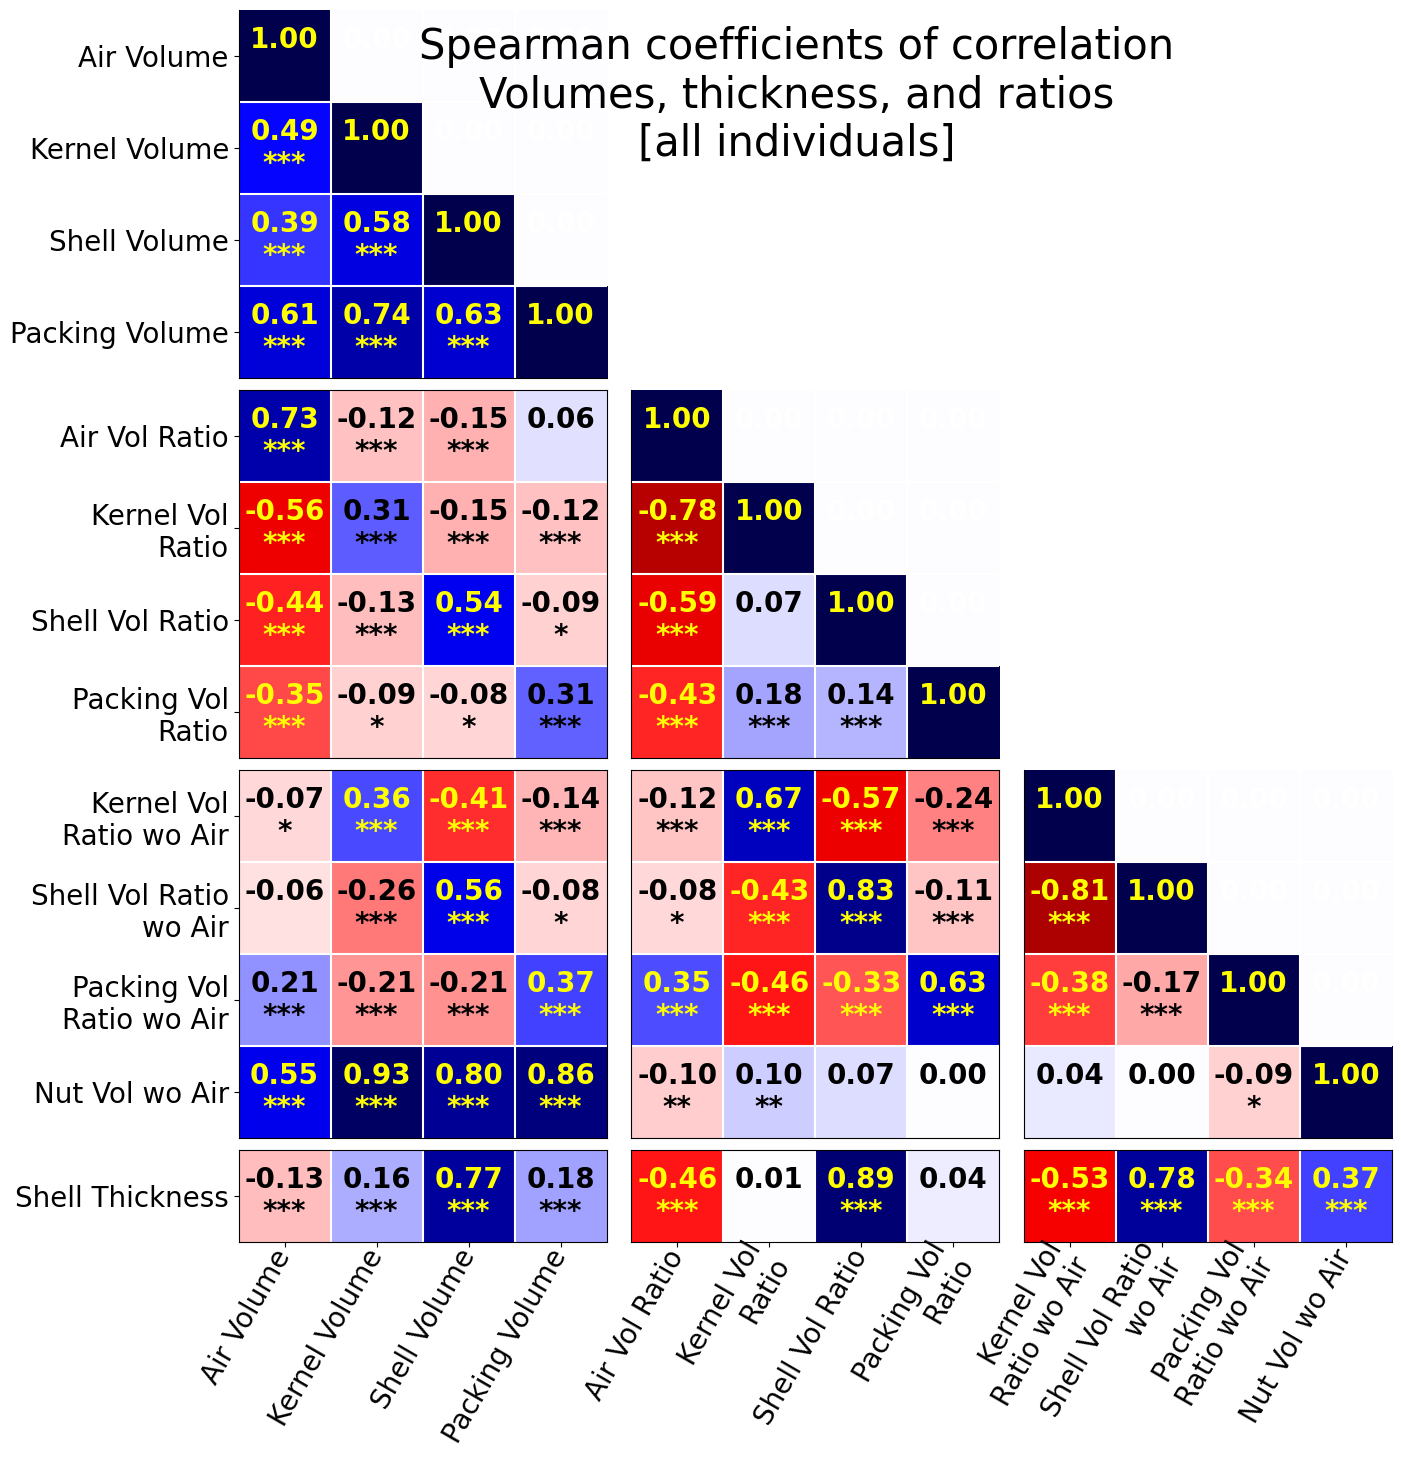

In [55]:
fs = 20
tw = 15
pt = 0.
fw = 'bold'
sig = ['', '*', '**', '***']
fig, ax = plt.subplots(4,3,figsize=(15,16), height_ratios=[4,4,4,1])
ax = np.atleast_1d(ax).ravel()

ss = [np.s_[:4, :4], None, None, 
      np.s_[4:8,:4], np.s_[4:8, 4:8], None,
      np.s_[-5:-1,:4], np.s_[-5:-1, 4:8], np.s_[-5:-1, -5:-1],
      np.s_[-1:,:4], np.s_[-1:, 4:8], np.s_[-1:, -5:-1]
     ]

for i in [0,3,4,6,7,8, 9,10,11]:
    aux = corr[ss[i]]
    ax[i].imshow(aux, cmap='seismic_r', vmin=-1, vmax=1)
    for j in range(aux.shape[0]):
        for k in range(aux.shape[1]):
            if np.abs(aux[j,k]) > 0.33:
                tcolor = 'yellow'
            elif aux[j,k] == 0:
                tcolor= 'white'
            else:
                tcolor = 'black'
            
            ax[i].text(k,j, '{:.2f}\n{}'.format((np.round(aux[j,k],2)), sig[pval_[ss[i]][j,k]]),
                        ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
            
    for j in range(3):
        ax[i].axvline(j+.5, color='w')
    ax[i].tick_params(labelsize=fs)
        

for i in [0,3,4,6,7,8]:
    for j in range(3):
        ax[i].axhline(j+.5, color='w')
    
for i in range(3):
    ax[9+i].set_xticks(range(4), 
                       [textwrap.fill(t,tw) for t in labels.col_labels.iloc[qtraits[ss[6+i][1]]+iniN]],
                       rotation=60, ha='right', va='center', rotation_mode='anchor')
    ax[3*i].set_yticks(range(4),
                       [textwrap.fill(t,tw) for t in labels.col_labels.iloc[qtraits[ss[3*i][0]]+iniN]])

ax[9].set_yticks([0], [labels.col_labels.iloc[qtraits[-1] + iniN]])

for i in [0,3,4,6,7,8]:
    ax[i].set_xticks([])
for i in [4,7,8,10,11]:
    ax[i].set_yticks([])

for i in [0,4,8]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
for i in [1,2,5]:
    fig.delaxes(ax[i])
    
fig.suptitle("Spearman coefficients of correlation\nVolumes, thickness, and ratios\n[all "+perbasis+"s]", fontsize=fs+10, y=.87)

plt.subplots_adjust(wspace=0.04, hspace=0.04)

filename = dst + 'vol_absolute_relative_thick_correlation_' +perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (8).

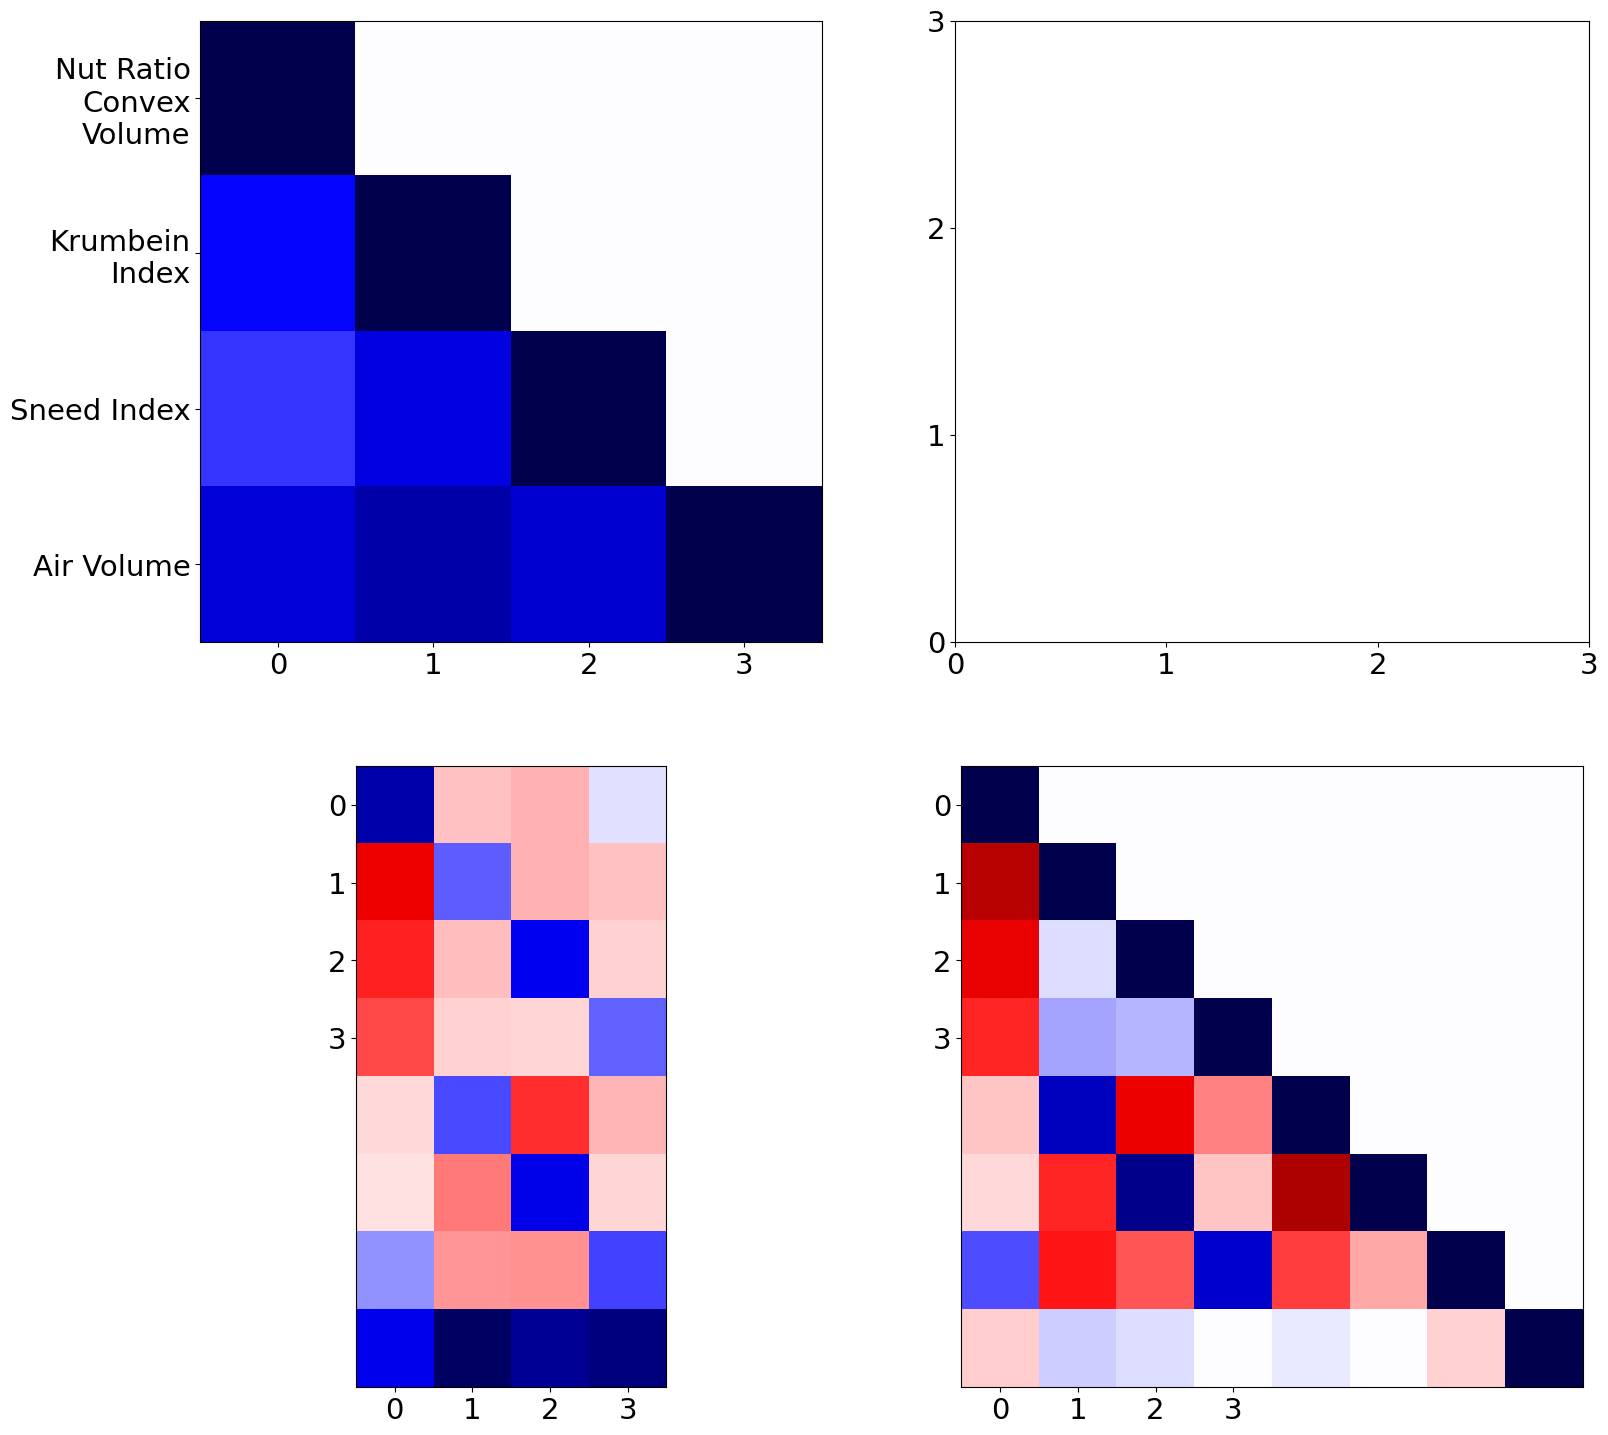

In [81]:
fs = 23
tw = 12
pt = 0.
fw = 'bold'
sig = ['', '*', '**', '***']
fig, ax = plt.subplots(2,2,figsize=(18,17.75))
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(corr[:4,:4], cmap='seismic_r', vmin=-1, vmax=1)
ax[2].imshow(corr[4:, :4], cmap='seismic_r', vmin=-1, vmax=1)
ax[3].imshow(corr[4:, 4:], cmap='seismic_r', vmin=-1, vmax=1)

for i in range(len(ax)):
    ax[i].set_xticks(np.arange(4))
    ax[i].set_yticks(np.arange(4))
    ax[i].tick_params(labelsize=fs-2)

ax[0].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[2].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[2].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[3].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[0].get_xaxis().set_ticks([])
ax[3].get_yaxis().set_ticks([])

for i in [0,3]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[0].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i,j],2)), sig[pval_[i,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
for i in range(4):
    for j in range(4):
        if np.abs(corr[i+4,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[2].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j],2)), sig[pval_[i+4,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i+4,j+4]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[3].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j+4],2)), sig[pval_[i+4,j+4]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
        
fig.delaxes(ax[1])

fig.suptitle("Spearman coefficients of correlation [per "+perbasis+"]", fontsize=fs+10)

fig.tight_layout()

filename = dst + 'vol_ratios_correlation_' +perbasis
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

../hpcc/results/trad/pearson_correlation


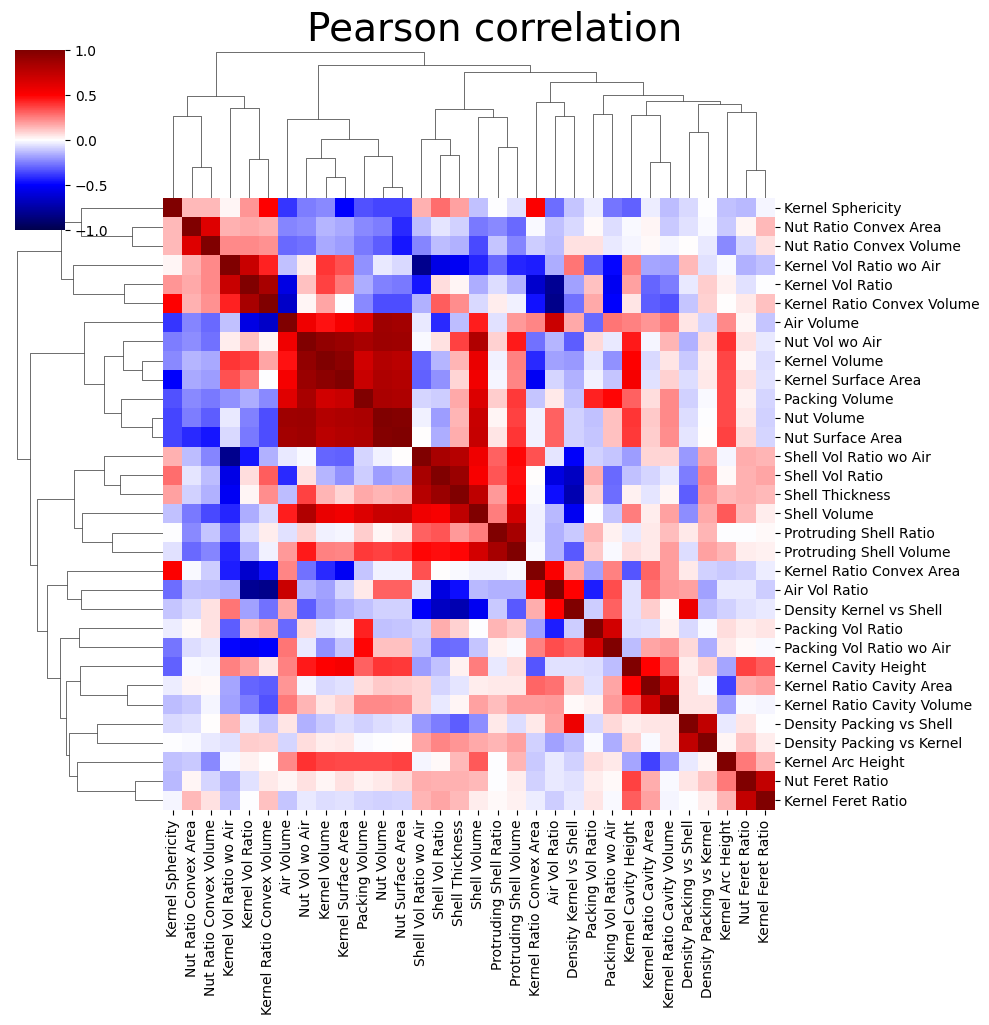

In [98]:
vmin, vmax = -1,1
cmap = 'seismic'
foo = pd.DataFrame(pcorrstat, columns=labels.col_labels.iloc[iniN:endN].values, 
                   index=labels.col_labels.iloc[iniN:endN].values)
foo = foo.drop(columns=foo.columns[dropsubset], index=foo.index[dropsubset])

sns.clustermap(foo, vmax=vmax, vmin=vmin, cmap=cmap);
plt.suptitle('Pearson correlation', fontsize=28, y=1.02);

filename = dst + 'pearson_correlation'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=200, format='pdf', bbox_inches='tight')

# Link to categorical traits from Pat Brown